# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание проекта
Заказчик исследования - сеть отелей "Как в гостях". Необходимо разработать модель машинного обучния, способную эффективно предсказывать отказ от брони. В случае, если модель предсказывает отказ, клиенту придется внести депозит 80% от стоимости за сутки и стоимость уборки. 
Ключевая метрика - прибыль компании.
## Цели
1. Разработать систему прогнозирования отказа от брони.
2. Данная система должна окупиться за тестовый период.
## Описание данных
* id — номер записи;
* adults — количество взрослых постояльцев;
* arrival_date_year — год заезда;
* arrival_date_month — месяц заезда;
* arrival_date_week_number — неделя заезда;
* arrival_date_day_of_month — день заезда;
* babies — количество младенцев;
* booking_changes — количество изменений параметров заказа;
* children — количество детей от 3 до 14 лет;
* country — гражданство постояльца;
* customer_type — тип заказчика:
* Contract — договор с юридическим лицом;
* Group — групповой заезд;
* Transient — не связано с договором или групповым заездом;
* Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* days_in_waiting_list — сколько дней заказ ожидал подтверждения;
* distribution_channel — канал дистрибуции заказа;
* is_canceled — отмена заказа;
* is_repeated_guest — признак того, что гость бронирует номер второй раз;
* lead_time — количество дней между датой бронирования и датой прибытия;
* meal — опции заказа:
* SC — нет дополнительных опций;
* BB — включён завтрак;
* HB — включён завтрак и обед;
* FB — включён завтрак, обед и ужин.
* previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
* previous_cancellations — количество отменённых заказов у клиента;
* required_car_parking_spaces — необходимость места для автомобиля;
* reserved_room_type — тип забронированной комнаты;
* stays_in_weekend_nights — количество ночей в выходные дни;
* stays_in_week_nights — количество ночей в будние дни;
* total_nights — общее количество ночей;
* total_of_special_requests — количество специальных отметок.

## Шаг 1. Откройте файлы с данными

### Импорт библиотек необходимых для анализа

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    recall_score, 
    precision_score,
    f1_score,
    classification_report,
    roc_curve, 
    roc_auc_score,
    confusion_matrix, 
    ConfusionMatrixDisplay
) 

In [2]:
#Настройка pandas
pd.set_option('display.max_columns', None)

### Загрузка данных

In [3]:
#open dataset
pth1 = '/datasets/'
pth2 = 'datasets/'

if os.path.exists(pth1):
    try:
        data_train = pd.read_csv('/datasets/hotel_train.csv')
        data_test = pd.read_csv('/datasets/hotel_test.csv')
        print('Датасет успешно считан')
    except:
        print('Возникли проблемы с чтением файлов 1')
elif os.path.exists(pth2):
    try:
        data_train = pd.read_csv('datasets/hotel_train.csv')
        data_test = pd.read_csv('datasets/hotel_test.csv')
        print('Датасет успешно считан')
    except:
        print('Возникли проблемы с чтением файлов 2')
else:
    print('Не найдена необходимая директория')

Датасет успешно считан


## Шаг 2. Предобработка и исследовательский анализ данных

### Проверка утверждений

Перед началом исследовательского анализа данных проверим следующие утверждения?
1. Столбец id уникален для data_train, data_test
2. Индексы id в data_train и data_test не имеют пересечений

In [4]:
print(f'Количество дубликатов в столбце id data_train: {data_train.duplicated().sum()}\n\
Количество дубликатов в столбце id data_test: {data_test.duplicated().sum()}\n\
id data_train и id data_test не имеют пересечений: {set(data_train.id).isdisjoint(set(data_test.id))}')

Количество дубликатов в столбце id data_train: 0
Количество дубликатов в столбце id data_test: 0
id data_train и id data_test не имеют пересечений: True


Действительно, id уникален для каждого из датасетов. и не имеет пересечений между собой.
1. Запомним индексы (id) каждого из датасетов
2. Объединим данные в один большой датасет, проведем исследовательский анализ данных и обработку.
3. Затем снова разъединим их на обучающий и проверочный датасет перед началом машинного обучения

In [5]:
data_train = data_train.set_index('id')
data_test = data_test.set_index('id')

In [6]:
train_indexes = data_train.index
test_indexes = data_test.index

In [7]:
data = pd.concat([data_train, data_test])

###  Пропуски в датасетах

Далее проверим данные на наличие пропусков

In [8]:
print(f'Суммарное количество пропусков во всем датасете: {data.isna().sum().sum()}')

Суммарное количество пропусков во всем датасете: 0


Пропусков нет вовсе.

### Сезонные коэффициенты

Добавим столбец season_coef со значениями:
1.4 - лето
1.2 - осень, весна
1 - зима

In [9]:
def seson_coef(row):
    month = row['arrival_date_month']
    if month in ['December', 'January', 'February']:
        return 1
    elif month in ['March', 'April', 'May','September', 'October', 'November']:
        return 1.2
    elif month in ['June','July', 'August' ]:
        return 1.4

In [10]:
data['season_coef'] = data.apply(lambda row: seson_coef(row), axis=1)
data.season_coef.unique()

array([1.4, 1.2, 1. ])

### Стоимость номера за ночь и обслуживания

In [11]:
data.reserved_room_type = data.reserved_room_type.str.replace(' ', '')

In [12]:
def room_price(row):
    if row['reserved_room_type'] == 'A':
        return 1000
    elif row['reserved_room_type'] == 'B':
        return 800
    elif row['reserved_room_type'] == 'C':
        return 600
    elif row['reserved_room_type'] == 'D':
        return 550
    elif row['reserved_room_type'] == 'E':
        return 500
    elif row['reserved_room_type'] == 'F':
        return 450
    elif row['reserved_room_type'] == 'G':
        return 350

In [13]:
data['room_price'] = data.apply(lambda row: room_price(row), axis=1)
data.room_price.unique()

array([1000,  600,  550,  500,  350,  450,  800], dtype=int64)

В датасете есть три взаимосвязанных колонки:
stays_in_weekend_nights, stays_in_week_nights, total_nights
Логика подсказывает, что:
$$
stays\_in\_weekend\_nights + stays\_in\_week\_nights =total\_nights
$$
Проверим, так ли это

In [14]:
(data.stays_in_week_nights + data.stays_in_weekend_nights == data.total_nights).unique()

array([ True])

Чтобы не попасть в дамми ловушку, столбец total night необходимо удалить

In [15]:
data = data.drop('total_nights', axis=1)

Вычислим для каждого гостя стоимость обслуживания за все время пребывания

In [16]:
def service_price(row):
    service_price_list = {
        'A': 400, 
        'B': 350,
        'C': 350,
        'D': 150,
        'E': 150,
        'F': 150,
        'G': 150
        
    }
    return service_price_list[row['reserved_room_type']]

In [17]:
data['service_price'] = data.apply(lambda row: service_price(row), axis=1)


### Выручка компании и прибыль

Создадим столбец revenue и profit. С полной выручкой и прибылью

In [18]:
data['revenue'] = (data.stays_in_week_nights + data.stays_in_weekend_nights) *\
    data.room_price * data.season_coef * (1 - data.is_canceled)
data['profit'] = (1 - data.is_canceled) * (data.revenue - data.service_price - \
    data.service_price * ((data.stays_in_week_nights + data.stays_in_weekend_nights) // 2)) \
    - data.is_canceled * (data.service_price + data.room_price * data.season_coef)

### Корреляция

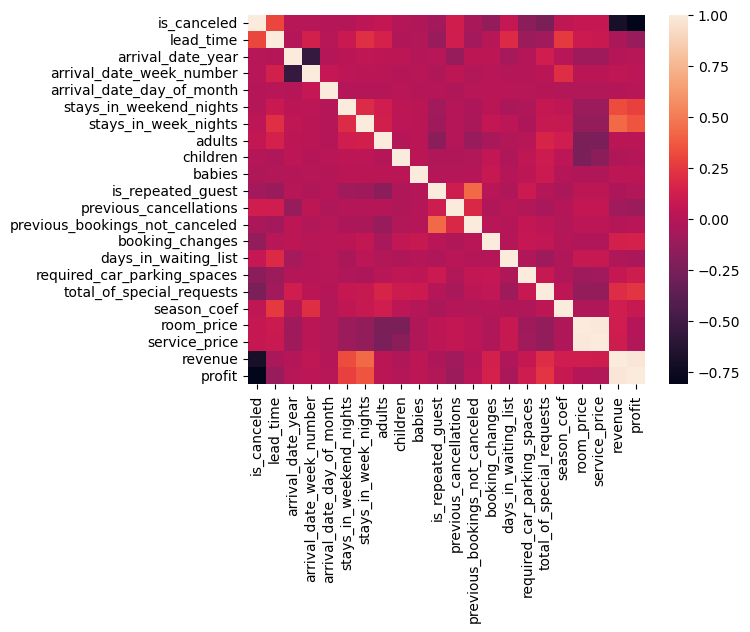

In [19]:
sns.heatmap(data.corr());

Выводы:
1. Сильная линейная связь между выручкой и прибылью с клиента (не самый интересный факт, ввиду очевидности)
2. Средняя связь между прибылью и количеством дней в номере (тоже предсказумое)
3. Есть средняя связь между повторным бронированием и тем, что гость не отменял предыдущее бронирование

### Типы данных

Приведем данные к логичному типу

In [20]:
data.loc[:, ['adults', 'children', 'babies']] = data.loc[:, ['adults', 'children', 'babies']].astype('int')


### Распределение величин

#### float

Посмотрим как распределены вещественные параметры

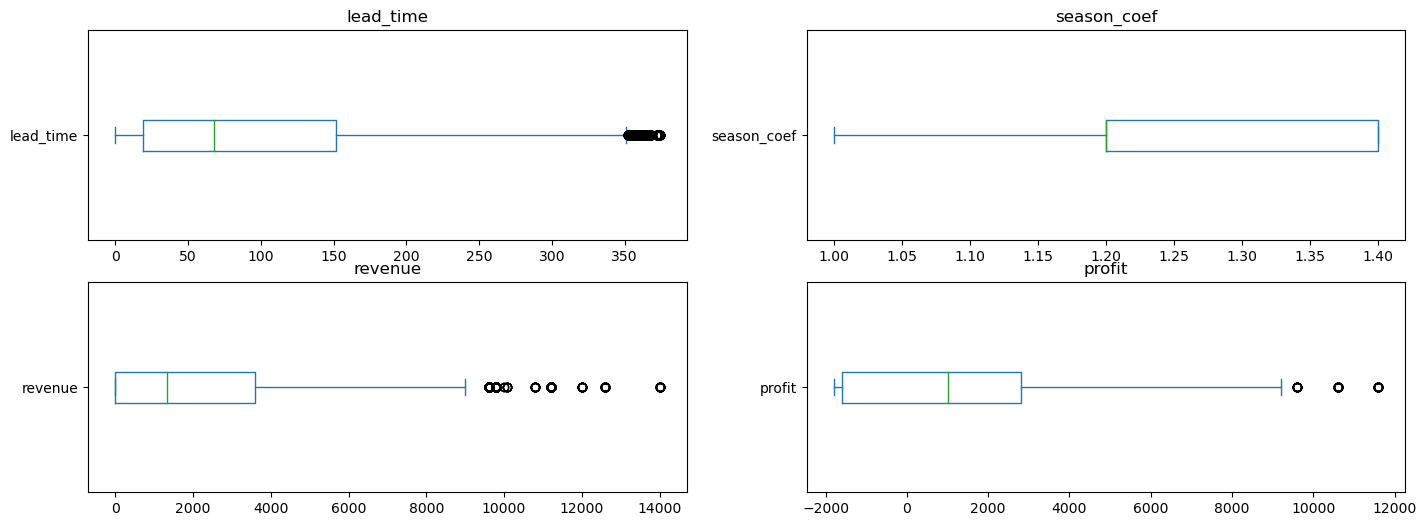

In [21]:
numeric_columns = list(data.dtypes.loc[(data.dtypes == 'float64')].index)
fig, ax = plt.subplots(2,2, figsize=(17, 6))
for index, column in enumerate(numeric_columns):
    data.loc[:, column].plot(kind='box', title=column, ax=ax[index //2, index % 2], vert=False)

#### object

Серьезных выбросов, не обнаружено

Исследуем распределение категориальных  переменных 

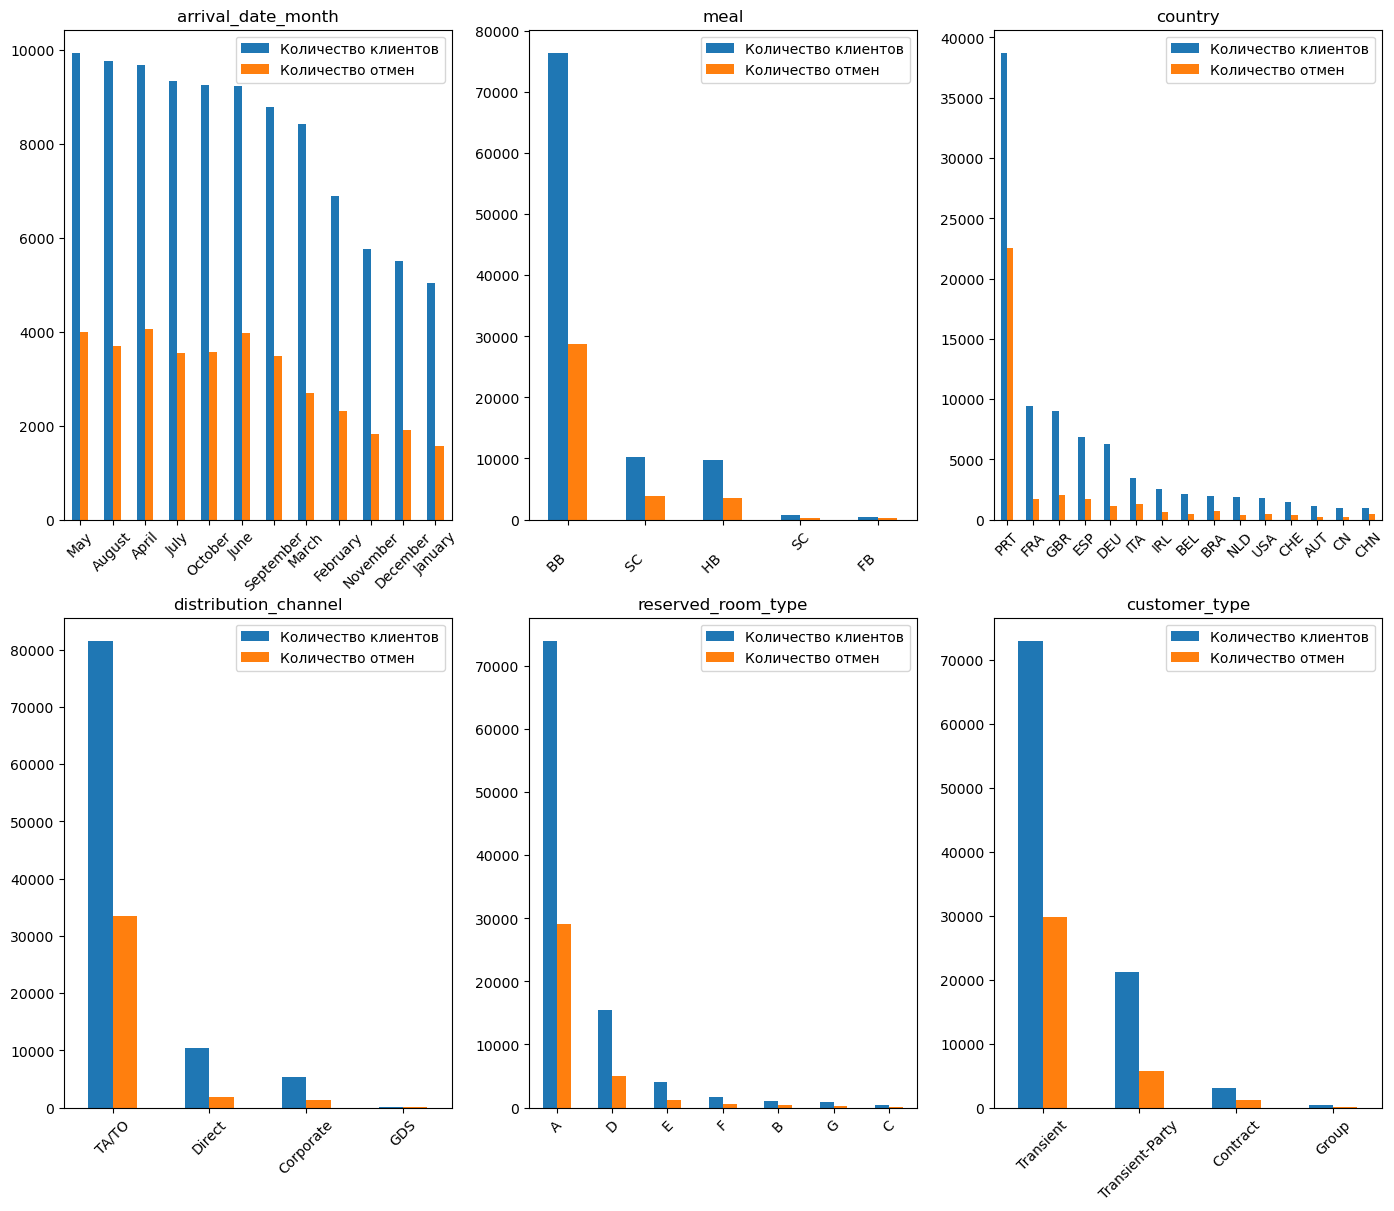

In [22]:
categorical_columns = list(data.dtypes.loc[(data.dtypes == 'object')].index)
fig, ax = plt.subplots(2,3, figsize=(17, 14))
for index, column in enumerate(categorical_columns[:]):
    data.loc[:, [column, 'is_canceled']]\
        .pivot_table(index=column, values='is_canceled', aggfunc=['count', 'sum'])\
            .sort_values(by=('count', 'is_canceled'), ascending=False)[:15]\
                .plot(kind='bar', legend=False, title=column, ax=ax[index // 3, index%3], rot=45, xlabel='')
    ax[index // 3, index%3].legend(['Количество клиентов', 'Количество отмен'])


Анализируя полученные гистограммы можно сделать ряд выводов:
1. Сезонные коэффициенты выбраны логично
2. Наиболее популярный тип питания: BB = включен завтрак
3. Вероятно наш отель расположен в Португалии. Так как большинство туристов именно оттуда. Также отель пользуется популярностью у других Европейских стран. Визуально кажется, что Португальцы чаще других отменяют бронирование.
4. Чаще всего отель бронируют через турагента или туроператора (TA/ TO). Реже напрямую
5. Наиболее популярные тип номера "A" - наиболее дорогой
6. Чаще всего это бронирование не связано с договором или групповым заездом

#### int

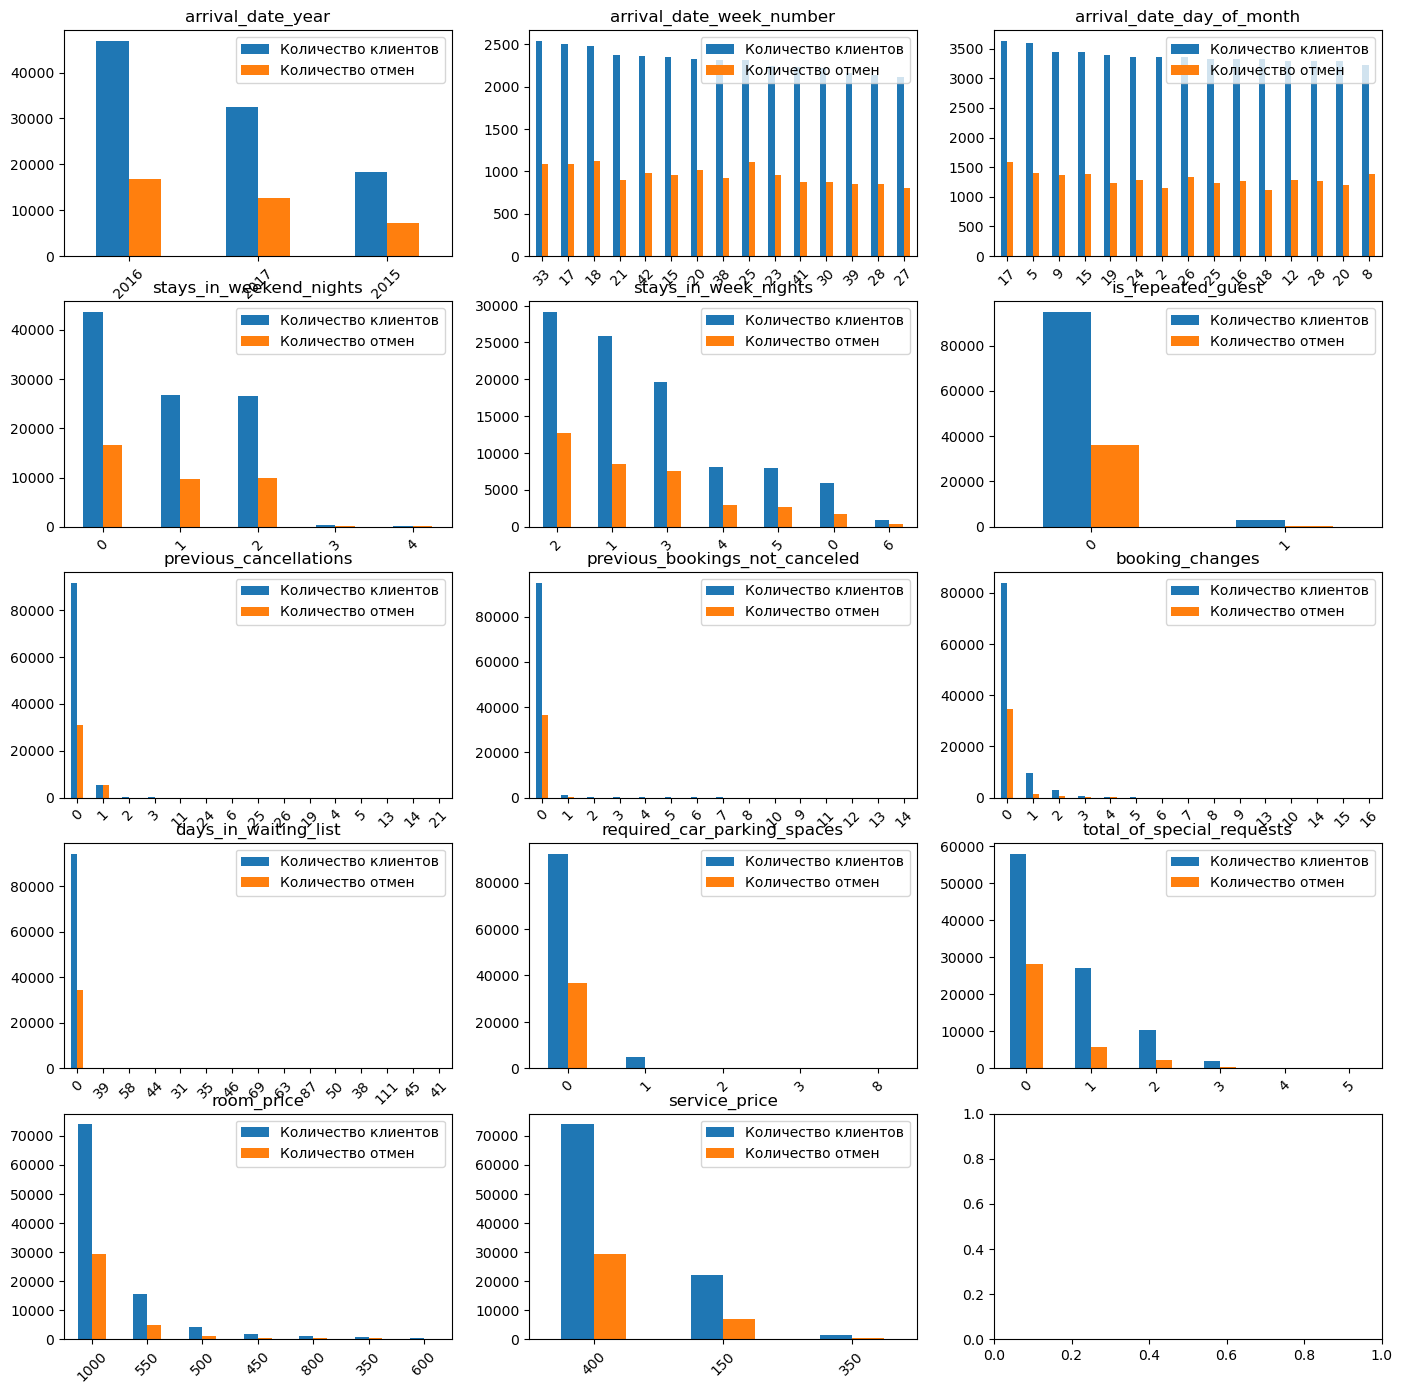

In [23]:
int_columns = list(data.dtypes.loc[(data.dtypes == 'int64')].index)[1:]
fig, ax = plt.subplots(5,3, figsize=(17, 17))
for index, column in enumerate(int_columns[:]):
    data.loc[:, [column, 'is_canceled']]\
        .pivot_table(index=column, values='is_canceled', aggfunc=['count', 'sum'])\
            .sort_values(by=('count', 'is_canceled'), ascending=False)[:15]\
                .plot(kind='bar', legend=False, title=column, ax=ax[index // 3, index%3], rot=45, xlabel='')
    ax[index // 3, index%3].legend(['Количество клиентов', 'Количество отмен'])


### Анализ портрета ненадежного заемщика

#### Lead_time

Исследуем, как вероятность отмены зависит от времени до бронирования:
1. Поделим времена бронирования на децили.
2. Построим стобчатую гистограмму среднего значения `is_canceled` в каждом дециле.

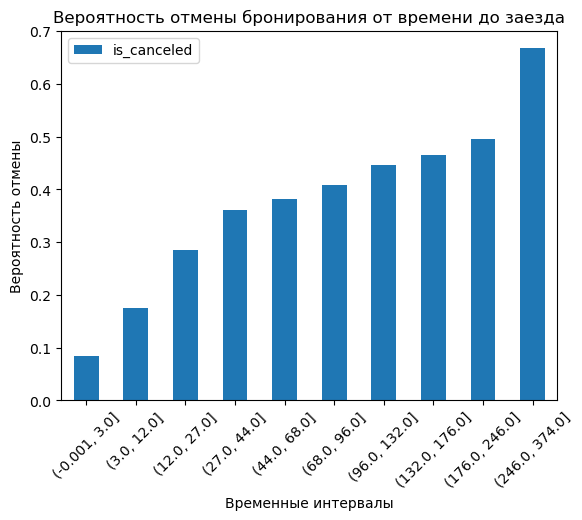

In [24]:
pd.concat([pd.qcut(data.lead_time, q=10), data.is_canceled],axis=1)\
    .pivot_table(index='lead_time', values='is_canceled')\
        .plot(kind='bar', rot=45, \
            title='Вероятность отмены бронирования от времени до заезда',\
                xlabel='Временные интервалы', ylabel='Вероятность отмены');

**Вероятность отмены брони растет с увеличением срока до заезда в отель**

#### arrival_date_month

Исследуем, как влияет месяц заезда на отмены

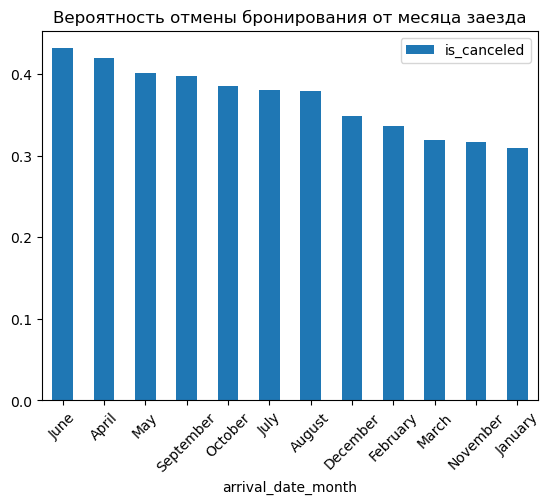

In [25]:
data.pivot_table(index='arrival_date_month', values='is_canceled', aggfunc='mean')\
    .sort_values(by='is_canceled', ascending=False)\
        .plot(kind='bar', rot=45, title='Вероятность отмены бронирования от месяца заезда');

**В сезонные месяцы вероятность отмены несколько выше, чем в зимний период**

#### adults, children, babies

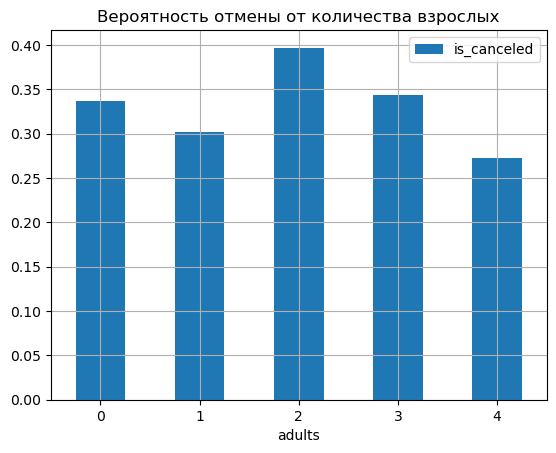

In [26]:
data.pivot_table(index='adults', values='is_canceled')\
    .plot(kind='bar', rot=0, grid=True, title='Вероятность отмены от количества взрослых');

In [27]:
data.pivot_table(index='adults', values='is_canceled', aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
adults,,
0,0.336170,235
1,0.302278,19492
2,0.396779,73217
3,0.343743,4675
4,0.272727,22


**Приезжающие парами отменяют бронирование чаще всего, при этом наиболее популярные варианты бронирования - 1 взрослый или 2 взрослых. По остальным категориям данных мало**

In [28]:
data.pivot_table(index='children', values='is_canceled', aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
children,,
0,0.376944,92072
1,0.316662,3559
2,0.399698,1989
3,0.333333,21


**По количество детей достаточно сложно сделать вывод, подавляющее большинство гостей без детей**

In [29]:
data.pivot_table(index='babies', values='is_canceled', aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
babies,,
0,0.376544,97014
1,0.169903,618
2,0.000000,7
9,0.000000,1
10,0.000000,1


**С младенцеми путешествуют редко, данных недостаточно для анализа**

#### meal

In [30]:
data.pivot_table(index='meal', values='is_canceled',  aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
meal,,
BB,0.375407,76381
FB,0.667351,487
HB,0.371995,9691
SC,0.247089,773
SC,0.372490,10309


Наиболее популярные типы питаниця:
1. Включен завтра (BB)
2. Без дополнительных опций (SC)
3. Завтрак и обед (HB)
Сделаем анализ по ним

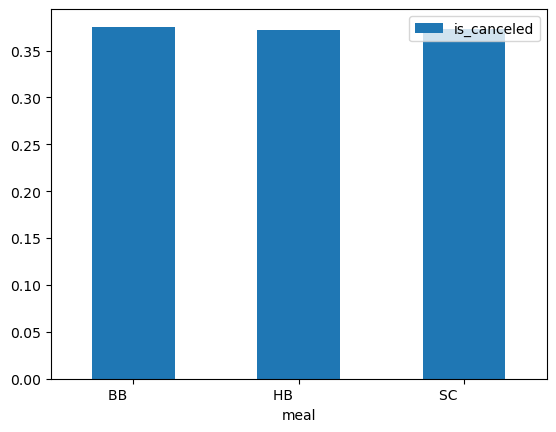

In [31]:
data.pivot_table(index='meal', values='is_canceled').iloc[[0,2,4]].plot(kind='bar', rot=0);

**Разница в типах питания несущественная**

#### country

В графе country много различных стран. При этом 95 % посетителей приходится на 22 страны. Анализируем их. 
Также это позволит не плодить огромное количество dummy переменных. 

In [32]:
popular_countries = data.country.value_counts(normalize=True)\
    .loc[data.country.value_counts(normalize=True).cumsum() < 0.95].index
popular_countries

Index(['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD',
       'USA', 'CHE', 'AUT', 'CN', 'CHN', 'SWE', 'POL', 'ISR', 'RUS', 'NOR',
       'ROU', 'FIN'],
      dtype='object')

In [33]:
data.country = data.country.where(data.country.isin(popular_countries), 'non_popular')

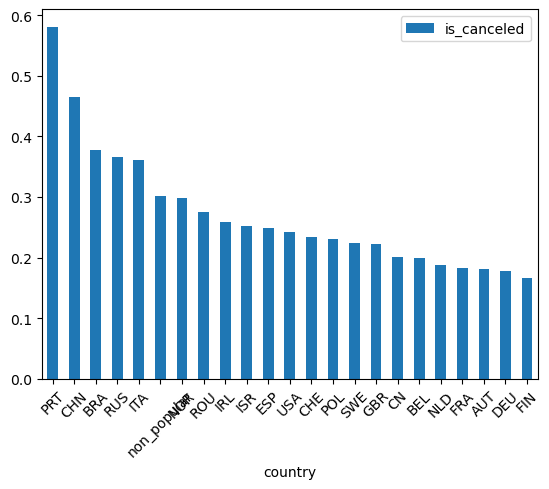

In [34]:
data.pivot_table(index='country', values='is_canceled')\
    .sort_values(by='is_canceled', ascending=False).plot(kind='bar', rot=45);

**Жители Португалии чемпионы по отмене бронирований. Почти 60% бронирований будет отменено**

#### distribution_channel

In [35]:
data.pivot_table(index='distribution_channel', values='is_canceled', aggfunc=['mean', 'count'])\
    .sort_values(by=('mean', 'is_canceled'), ascending=False)

,mean,count
,is_canceled,is_canceled
distribution_channel,,
TA/TO,0.411470,81537
Corporate,0.228756,5425
GDS,0.179348,184
Direct,0.172558,10495


**Наиболее популярный канал дистрибуции - через туроператора, по нему же чаще всего происходят отмены. Реже всего люди отменяют, если выбрали отель напрямую.**

#### is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes

In [36]:
data.loc[:, ['is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', \
    'booking_changes', 'is_canceled']].corr()['is_canceled']\
        .to_frame().style.background_gradient('coolwarm')

,is_canceled
is_repeated_guest,-0.069861
previous_cancellations,0.119424
previous_bookings_not_canceled,-0.052694
booking_changes,-0.140665
is_canceled,1.000000


**Линейной зависимости между параметрами нет**

#### reserved_room_type

In [37]:
data.pivot_table(index='reserved_room_type', values='is_canceled', aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
reserved_room_type,,
A,0.394433,73972
B,0.326996,1052
C,0.307692,429
D,0.322566,15510
E,0.283724,4092
F,0.298368,1716
G,0.351724,870


**Чаще всего люди бронируют категории номеров A и D. При этом большая часть отмен бронирований приходится на номера типа А**

#### days_in_waiting_list

In [38]:
print(f'Количество клиентов, ожидающих подтверждение больше 0 дней: {(data.days_in_waiting_list != 0).sum()}')

Количество клиентов, ожидающих подтверждение больше 0 дней: 3401


Количество клиентов, ожидающих подтверждение больше 0 дней совсем немного в рамках нашего датасета. Сравним их с основной группой, получающих подвтерждение сразу

In [39]:
waiting = data.query('days_in_waiting_list != 0').is_canceled.mean()
non_waiting = data.query('days_in_waiting_list == 0').is_canceled.mean()
print(f'Отмен бронирований среди получающих подтверждение бронирования с задержкой: {waiting:.1%}\n\
Отмен бронирований среди получающих подтверждение бронирования без задержки: {non_waiting:.1%}')

Отмен бронирований среди получающих подтверждение бронирования с задержкой: 65.4%
Отмен бронирований среди получающих подтверждение бронирования без задержки: 36.5%


**Пользователей лучше не заставлять ждать - им это не нравится**

#### customer_type

In [40]:
data.pivot_table(index='customer_type', values='is_canceled', aggfunc=['mean', 'count'])

,mean,count
,is_canceled,is_canceled
customer_type,,
Contract,0.365539,3105
Group,0.070796,452
Transient,0.408778,72954
Transient-Party,0.267203,21130


**Физлица основные постояльцы нашего отеля, остальные категории покупателей представлены слабо для анализа**

## Вывод по блоку "Исследовательский анализ данных"

* Столбец id уникален, данные объединены и обработаны вместе
* В датасете отсутствуют пропуски и дубликаты
* Аномальных выбросов в количественных данных не обнаружено
* Сезонные коэффициенты выбраны логично
* Вероятно наш отель расположен в Португалии. Так как большинство туристов именно оттуда.
* Наиболее популярные тип номера "A" - наиболее дорогой
* Чаще всего это бронирование не связано с договором или групповым заездом


## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Разработка модели машинного обучения, способной прогнозировать необходимость введения депозита для клиента при бронировании номера. <br>

Обязательным условием является повышение прибыли больше, чем на 400_000 руб (стоимость разработки) за тестовый период.


In [41]:
print(f'Прибыль компании в тестовый период до внедрения машинного обучения: {data.profit[test_indexes].sum():,.0f}\n\
Выручка компании в тестовый период до внедрения машинного обучения: {data.revenue[test_indexes].sum():,.0f}\n\
Количество клиентов отменяющих бронь: {data.is_canceled.mean():.1%}')


Прибыль компании в тестовый период до внедрения машинного обучения: 32,582,920
Выручка компании в тестовый период до внедрения машинного обучения: 65,288,980
Количество клиентов отменяющих бронь: 37.5%


Почти половина выручки пропадает из-за клиентов отменивших бронь!

## Вывод по блоку "Формулировка ML задачи"
* Перед нами задача бинарной классификации
* Основной метрикой является высокая прибыль компании

## Шаг 4. Разработка модели ML

### Dummy переменные

In [42]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,season_coef,room_price,service_price,revenue,profit,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_SC,country_BEL,country_BRA,country_CHE,country_CHN,country_CN,country_DEU,country_ESP,country_FIN,country_FRA,country_GBR,country_IRL,country_ISR,country_ITA,country_NLD,country_NOR,country_POL,country_PRT,country_ROU,country_RUS,country_SWE,country_USA,country_non_popular,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,1.4,1000,400,1400.0,1000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,14.0,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,1.4,1000,400,2800.0,2000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0.0,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,0,1.4,600,350,1680.0,980.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,0,9.0,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,1.4,600,350,1680.0,980.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,1,85.0,2015,27,1,0,3,2,0,0,0,0,0,0,0,0,1,1.4,1000,400,0.0,-1800.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Перед нами задачи классификации - необходимо предсказывать столбец `is_canceled` по остальным.
Проверять на эффективность будем три модели:
1. Логистическая регрессия
2. Случайный лес
3. Модель максимальной прибыли

Ключевая метрика: Прибыль компании

Определяем признаки и цели. Сбрасываем созданные колонки из признаков

In [43]:
data_test = data.loc[test_indexes]
data_train = data.loc[train_indexes]

In [44]:
data_test_target = data_test.is_canceled
data_test_features = data_test.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)
data_train_target = data_train.is_canceled
data_train_features = data_train.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)


### Разбиваем на обучающую и валидационную выборки

In [45]:
features_train, features_valid, target_train, target_valid = \
train_test_split(data_train_features, data_train_target, test_size=0.25, random_state=42, stratify=data_train_target)

### Масштабирование признаков

In [46]:
def features_scalling(features_train, features_valid, features_test):
    scaler = StandardScaler()
    numeric_columns = list(features_train.dtypes.loc[(features_train.dtypes == 'float64') | \
         (features_train.dtypes == 'int64') | (features_train.dtypes == 'int32') | \
                                                     (features_train.dtypes == 'uint8')].index)
    scaler.fit(features_train.loc[:, numeric_columns])
    features_train.loc[:, numeric_columns] = pd.DataFrame(scaler.transform(features_train.loc[:, numeric_columns]),\
                                    index=features_train.index, columns=numeric_columns)
    features_valid.loc[:, numeric_columns] = pd.DataFrame(scaler.transform(features_valid.loc[:, numeric_columns]),\
                                     index=features_valid.index, columns=numeric_columns)
    features_test.loc[:, numeric_columns] = pd.DataFrame(scaler.transform(features_test.loc[:, numeric_columns]), \
                                     index=features_test.index, columns=numeric_columns)
    return features_train, features_valid, features_test

In [47]:
features_train, features_valid, data_test_features = \
features_scalling(features_train, features_valid, data_test_features)

### Логистическая регрессия

In [48]:
model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(features_train, target_train)
predictions_is_canceled = model.predict(data_test_features)
print(f'Точность логистической регрессии \n\
На валидационной выборке: {model.score(features_valid, target_valid):.1%}\n\
На тестовой выборке: {model.score(data_test_features, data_test_target):.1%}\n\
В сравнении с константной моделью, предсказывающий наиболее популярный класс:\
    {data_test_target.value_counts(normalize=True)[0]:.1%}')


Точность логистической регрессии 
На валидационной выборке: 79.7%
На тестовой выборке: 68.8%
В сравнении с константной моделью, предсказывающий наиболее популярный класс:    61.2%


In [49]:
print(classification_report(data_test_target, predictions_is_canceled))

              precision    recall  f1-score   support

           0       0.86      0.58      0.69     19821
           1       0.56      0.85      0.68     12591

    accuracy                           0.69     32412
   macro avg       0.71      0.72      0.69     32412
weighted avg       0.75      0.69      0.69     32412



Результаты неплохие, проверим, как увеличилась прибыль отеля при использовании депозита

In [50]:
data_test.insert(0, 'pred_is_canceled', predictions_is_canceled)

Логика столбца new_profit:
1. Если клиент приехал `(is_canceled == 0)`, то прибыль будет такая же как и раньше (депозит учитывается)
2. Если клиент не приехал `(is_canceled == 1)` , но модель дает неверное предсказание `(pred_is_canceled == 0)`, тогда мы несем полные убытки, как и раньше (стоимость ночи + уборка)
3.  Если клиент не приехал `(is_canceled == 1)`, но модель дает верное предсказание `(pred_is_canceled == 1)`, тогда его депозит в (стоимость ночи + уборка) * 0.8 сгорает. И наши убытки составляют 20% от того, что было раньше

Проверочные данные в табличке

In [51]:
data_test['new_profit'] = (1 - data_test.is_canceled) * data.profit + data_test.is_canceled * \
    (1-data_test.pred_is_canceled) * data_test.profit + data_test.is_canceled * data_test.pred_is_canceled * \
        data_test.profit * 0.2
data_test.loc[[97899, 6087, 6089], ['pred_is_canceled', 'is_canceled','stays_in_weekend_nights',\
    'stays_in_week_nights', 'room_price', 'season_coef', 'service_price', 'profit', 'new_profit']]

,pred_is_canceled,is_canceled,stays_in_weekend_nights,stays_in_week_nights,room_price,season_coef,service_price,profit,new_profit
id,,,,,,,,,
97899,1,0,2,4,1000,1.4,400,6800.0,6800.0
6087,0,1,2,2,1000,1.0,400,-1400.0,-1400.0
6089,1,1,2,2,1000,1.0,400,-1400.0,-280.0


In [52]:
print(f'Прибыль отеля до внедрения модели: {data_test.profit.sum():,.0f}\n\
Прибыль отеля после внедрения модели: {data_test.new_profit.sum():,.0f} \n\
Прибыль увеличилась в {data_test.new_profit.sum() / data_test.profit.sum():.2f}раз ')


Прибыль отеля до внедрения модели: 32,582,920
Прибыль отеля после внедрения модели: 45,034,392 
Прибыль увеличилась в 1.38раз 


### Случайный лес

Для работы модели случайного леса нет необходимости в масштабировании признаков. Реализуем ее:

In [53]:
data_test = data.loc[test_indexes]
data_train = data.loc[train_indexes]
data_test_target = data_test.is_canceled
data_test_features = data_test.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)
data_train_target = data_train.is_canceled
data_train_features = data_train.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)
features_train, features_valid, target_train, \
    target_valid = train_test_split(data_train_features, data_train_target, \
        test_size=0.25, random_state=42, stratify=data_train_target)

In [54]:
best_forest_model = None
best_profit_increase = 1
for depth in tqdm(range(5,15)):
    for est in range(1,101, 10):
        for leaf in range(1,5):
            #initialize model
            model = RandomForestClassifier(random_state=42, \
                max_depth=depth, n_estimators=est, min_samples_leaf=leaf, class_weight='balanced')
            model.fit(features_train, target_train)
            #predictions for valid features
            pred_is_canceled = model.predict(features_valid)
            # count new profit
            data_valid = data_train.loc[features_valid.index]
            data_valid['pred_is_canceled'] = pred_is_canceled
            data_valid['new_profit'] = (1 - data_valid.is_canceled) * data.profit \
                + data_valid.is_canceled * (1-data_valid.pred_is_canceled) * data_valid.profit \
                    + data_valid.is_canceled * data_valid.pred_is_canceled * data_valid.profit * 0.2
            if data_valid['new_profit'].sum() > data_valid['profit'].sum():
                best_forest_model = model
                best_profit_increase = data_valid['new_profit'].sum() / data_valid['profit'].sum()
                
print(f'Прибыль на валидационной выборке увеличилась в: {best_profit_increase:.2f} раз')
                

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:15<00:00, 43.56s/it]

Прибыль на валидационной выборке увеличилась в: 1.35 раз


In [55]:
predictions_test = best_forest_model.predict(data_test_features)

In [56]:
print(classification_report(data_test_target, predictions_test))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     19821
           1       0.75      0.62      0.68     12591

    accuracy                           0.77     32412
   macro avg       0.76      0.74      0.75     32412
weighted avg       0.77      0.77      0.77     32412



In [57]:
data_test['pred_is_canceled'] = predictions_test

In [58]:
data_test['new_profit'] = (1 - data_test.is_canceled) * data.profit\
    + data_test.is_canceled * (1-data_test.pred_is_canceled) * data_test.profit\
        + data_test.is_canceled * data_test.pred_is_canceled * data_test.profit * 0.2

### Модель максимальной прибыли

В моем понимании задание получилось несколько неполное. Получается, что введенный депозит для клиента выгоден всегда, потому что:
1. Клиент приехал = прибыль не изменилась
2. Клиент не приехал = убытки меньше
В такой ситуации выгоднее всего просто сделать обязательный депозит `pred_is_cancelded = 1` для всех клиентов. Таким образом, мы максимизируем метрику recall и найдем всех "прогульщиков" и получим максимальную прибыль. Ведь нас никак не штрафуют за ошибки!

In [59]:
data_test = data.loc[test_indexes]
data_train = data.loc[train_indexes]

In [60]:
data_test_target = data_test.is_canceled
data_test_features = data_test.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)
data_train_target = data_train.is_canceled
data_train_features = data_train.drop(['is_canceled', 'season_coef', 'room_price', 'revenue', 'profit'], axis=1)


In [61]:
data_test['pred_is_canceled'] = 1
data_test['new_profit'] = (1 - data_test.is_canceled) \
    * data.profit + data_test.is_canceled * (1-data_test.pred_is_canceled) * \
        data_test.profit + data_test.is_canceled * data_test.pred_is_canceled * data_test.profit * 0.2
print(f'Прибыль компании до внедрения модели: {data_test.profit.sum():,.0f}\n\
Прибыль компании после внедрения модели: {data_test.new_profit.sum():,.0f}\n\
Прибыль за тестовый период увеличилась в \
    {data_test.new_profit.sum() / data_test.profit.sum():.2f} раза или на \
        {(data_test.new_profit.sum() - data_test.profit.sum()) / 10**6:.1f} млн руб')

Прибыль компании до внедрения модели: 32,582,920
Прибыль компании после внедрения модели: 47,016,168
Прибыль за тестовый период увеличилась в     1.44 раза или на         14.4 млн руб


In [62]:
print(classification_report(data_test.is_canceled, data_test.pred_is_canceled))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19821
           1       0.39      1.00      0.56     12591

    accuracy                           0.39     32412
   macro avg       0.19      0.50      0.28     32412
weighted avg       0.15      0.39      0.22     32412



C:\Users\miros\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miros\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miros\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Вывод по блоку "разработка ML модели"
1. Введение депозита с рассмотренной точки зрения исключительно положительный шаг. Прибыль всегда получит неотрицательный рост. В реальной жизни депозиты могут отпугивать клиентов от бронирования отеля и нужно это учитывать.
2. Модель логистической регрессии оказалась предпочтительней для максимизации прибыли, в сравнении с моделью случайного леса. Она дала схожий с моделью случайного леса f1-score 0.68 и 0.68 соответственно. При этом метрика recall у логистической регрессии выше 0.85 против 0.62 у случайного леса. В противовес, модель случайного леса покала лучше результаты в точности (0.75 лес против 0.56 регрессия). Для нас важнее полнота (метрика recall)
3. Максимально прибыль удалось увеличить на 14.4 млн, выбрав константную модуль, сделав метрику recall = 1. Тогда f1-score становится 0.56, а точность нашей модели падает до 0.39 (доли отменяющих бронь)

## Шаг 5. Опишите портрет «ненадёжного» клиента

1. Забронировал отель как можно раньше до заезда
2. Собирается приехать в высокий сезон (Лучше всего июнь)
3. В бронировании указано, что проживать планируют 2 взрослых
4. Бронирование сделанно из Португалии
5. Бронирование сделано через туроперато или турагента
6. Забронировал наиболее дорогой тип комнаты (A)
7. Бронирование подтверждено не сразу
8. Не является корпоративным клиентом

## Шаг 6. Напишите общий вывод

### Общий вывод

1. Разработана система прогнозирования отказа от брони, окупающаяся за тестовый период
2. Наиболее эффективной моделью с точки зрения максимизации прибыли оказалась модель тотального введения депозитов для каждого клиента. Прибыль получила прирост в 14.4 млн руб на тестовом периоде. При этом данныя модель имеет никую точность и ошибается чаще, чем дает верное предсказание
3. Оптимальной моделью на мой взгляд оказалась модель логистической регрессии. Позволяющая находить 85 % клиентов планирующих отменить бронь. Прибыль при использовании такой модели увеличивается на 38% или на 12.5 млн руб. При этом данная модель имеет точность дает верное предсказание по отмене брони в 56% случаев.
4. Модель случайного леса, показала высокие результаты с точки зрения точности 75%. При этом смогла найти только 62% клиентов планирующих отмену бронирования. Также, на обучение данной модели тратиться значительно больше времени в сравнении с остальными
5. Наиболее важными характеристиками ненадежного клиента оказались:
* Бронирование задолго до заезда
* Бронирование сделано из Португалии
* Подтверждение получено не сразу